In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [2]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)
print(f"Number of GPUs available: {torch.cuda.device_count()}")  # In số lượng GPU
print(f"cuda=: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Number of GPUs available: 2
cuda=: True


In [3]:
BATCH_SIZE = 16
if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    BATCH_SIZE = 32
    print('BATCH_SIZE',BATCH_SIZE)

BATCH_SIZE 32


In [4]:
# Đọc dữ liệu từ file txt (có cột "content" và "label" phân tách bằng tab)
def get_data(path):
    df = pd.read_csv(path, sep="\t", names=["Sentence", "Emotion"], header=0)
    return df


train_df = get_data('/kaggle/input/sentiment/train_data.txt')
test_df = get_data('/kaggle/input/sentiment/test_data.txt')
# We will use Kfold later
N_SPLITS = 8
skf = StratifiedKFold(n_splits=N_SPLITS)

# Reset index trước khi chia KFold để tránh lỗi KeyError
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Gán cột "kfold"
train_df["kfold"] = -1  # Khởi tạo cột "kfold"

for fold, (_, val_idx) in enumerate(skf.split(X=train_df, y=train_df["Emotion"])):
    train_df.loc[val_idx, "kfold"] = fold  # Gán fold vào từng hàng
    
# Kiểm tra kích thước các tập dữ liệu
print(f"Train size: {len(train_df)} | Test size: {len(test_df)}")



Train size: 13556 | Test size: 1506


In [5]:
train_df.info()
print('----')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13556 entries, 0 to 13555
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  13556 non-null  object
 1   Emotion   13556 non-null  object
 2   kfold     13556 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 317.8+ KB
----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  1506 non-null   object
 1   Emotion   1506 non-null   object
dtypes: object(2)
memory usage: 23.7+ KB


<Axes: xlabel='Emotion', ylabel='count'>

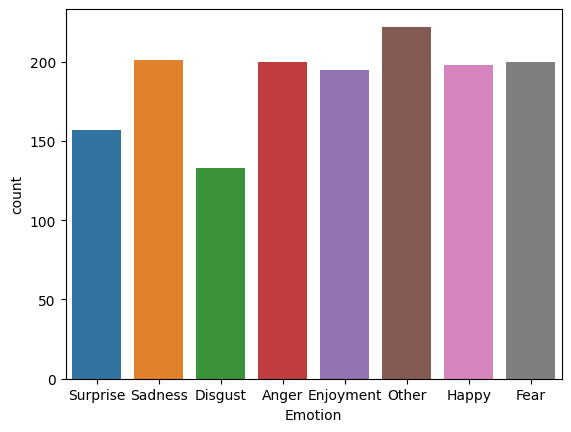

In [6]:
sns.countplot(x='Emotion', data=test_df)

<Axes: xlabel='Emotion', ylabel='count'>

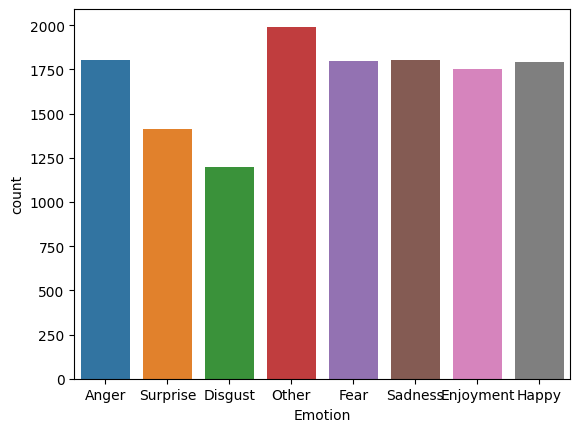

In [7]:
sns.countplot(x='Emotion', data=train_df)

In [8]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", use_fast=False)

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [9]:
LABEL_MAP = {
        "Enjoyment": 0,
        "Disgust": 1,
        "Sadness": 2,
        "Anger": 3,
        "Surprise": 4,
        "Fear": 5,
        "Happy": 6,
        "Other": 7
}

def labelEncoder(text)->int:
    return LABEL_MAP.get(text, 7)

def labelDecoder(number:int)->str:
    REVERSE_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
    return REVERSE_LABEL_MAP.get(number, "Other") 

# Test labelEncoder
print(labelEncoder("Happy"))       # Output: 6
print(labelEncoder("Unknown"))     # Output: 7 (Other)

# Test labelDecoder
print(labelDecoder(6))             # Output: Happy
print(labelDecoder(10))            # Output: Other


6
7
Happy
Other


In [10]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        text = row["Sentence"]
        label = labelEncoder(row['Emotion'])

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


In [11]:
# test
# Tạo DataFrame mẫu
data = {
    "Sentence": ["Tôi rất vui"],
    "Emotion": ["Sadness"]
}
df = pd.DataFrame(data)

# Khởi tạo dataset
dataset = SentimentDataset(df, tokenizer, max_len=10)

# Test __getitem__
sample = dataset[0]  # Lấy mẫu đầu tiên
print("Text:", sample["text"])
print("Input IDs:", sample["input_ids"])
print("Attention Mask:", sample["attention_masks"])
print("Target Label:", sample["targets"])

Text: Tôi rất vui
Input IDs: tensor([  0, 218,  59, 911,   2,   1,   1,   1,   1,   1])
Attention Mask: tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])
Target Label: tensor(2)


Text(0.5, 9.444444444444438, 'Token Count')

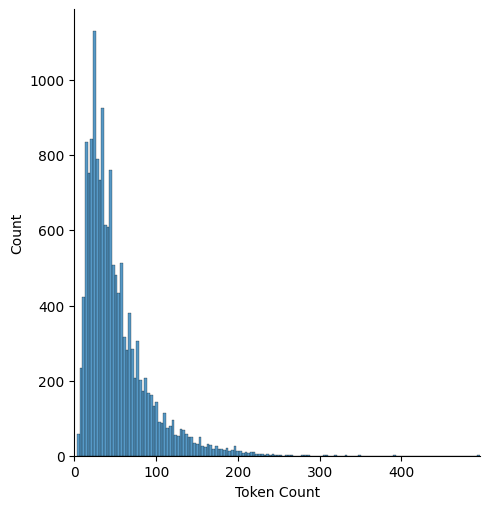

In [12]:
# Distribution of length of Sentence
all_data = train_df.Sentence.tolist() + test_df.Sentence.tolist()
all_data = [' '.join(text) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

In [13]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes=8):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base-v2")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

In [14]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())
    
    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)


In [15]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = SentimentDataset(df_train, tokenizer, max_len=256)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=256)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    
    return train_loader, valid_loader

In [16]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=8).to(device)

    # Bọc mô hình bằng DataParallel nếu có nhiều hơn 1 GPU
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)  # Sử dụng cả 2 GPU
        
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    EPOCHS = 10
    total_steps = len(train_loader) * EPOCHS
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer, 
                num_warmup_steps=round(total_steps * 0.1), 
                num_training_steps=total_steps)
    
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            # Lưu state_dict của mô hình gốc (không có tiền tố "module.")
            state_dict = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
            torch.save(state_dict, f'/kaggle/working/phobert_fold{fold+1}.pth')
            best_acc = val_acc
            print(f'Epoch {epoch+1} is selected')

-----------Fold: 1 ------------------


pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Epoch 1/10
------------------------------
Train Accuracy: 0.2611921423151505 Loss: 1.9860028732176418
Valid Accuracy: 0.4631268436578171 Loss: 1.5734977024906087
Epoch 1 is selected
Epoch 2/10
------------------------------
Train Accuracy: 0.5305623471882641 Loss: 1.389028047133649
Valid Accuracy: 0.5781710914454277 Loss: 1.2254843374468245
Epoch 2 is selected
Epoch 3/10
------------------------------
Train Accuracy: 0.6491864092403676 Loss: 1.0494694304916095
Valid Accuracy: 0.6070796460176991 Loss: 1.142650377075627
Epoch 3 is selected
Epoch 4/10
------------------------------
Train Accuracy: 0.7211027737964759 Loss: 0.8461894160011065
Valid Accuracy: 0.6241887905604719 Loss: 1.1576049586512007
Epoch 4 is selected
Epoch 5/10
------------------------------
Train Accuracy: 0.7839979765618413 Loss: 0.6755478926746029
Valid Accuracy: 0.6100294985250737 Loss: 1.1950156621213228
Epoch 6/10
------------------------------
Train Accuracy: 0.8257313885844364 Loss: 0.5511819089680027
Valid Accu

In [17]:
def test_kfold(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=8)
        model.to(device)
        model.load_state_dict(torch.load(f'/kaggle/working/phobert_fold{fold+1}.pth'))
        # Bọc mô hình bằng DataParallel nếu có nhiều hơn 1 GPU
        if torch.cuda.is_available() and torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)  # Sử dụng cả 2 GPU
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)
        
        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)
    
    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    print(classification_report(real_values, predicts, target_names=list(LABEL_MAP.keys())))
    return real_values, predicts

In [18]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=256)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
real_values, predicts = test_kfold(test_loader)

              precision    recall  f1-score   support

   Enjoyment       0.67      0.72      0.69       195
     Disgust       0.50      0.58      0.53       133
     Sadness       0.64      0.64      0.64       201
       Anger       0.64      0.48      0.55       200
    Surprise       0.65      0.72      0.68       157
        Fear       0.79      0.82      0.81       200
       Happy       0.61      0.64      0.63       198
       Other       0.71      0.64      0.67       222

    accuracy                           0.66      1506
   macro avg       0.65      0.66      0.65      1506
weighted avg       0.66      0.66      0.66      1506



<Axes: >

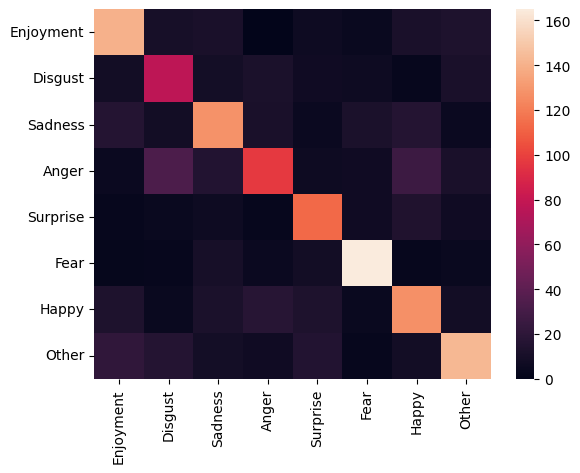

In [19]:
class_names = list(LABEL_MAP.keys())
sns.heatmap(
    confusion_matrix(real_values, predicts), 
    annot=False, 
    xticklabels = class_names, 
    yticklabels = class_names
)

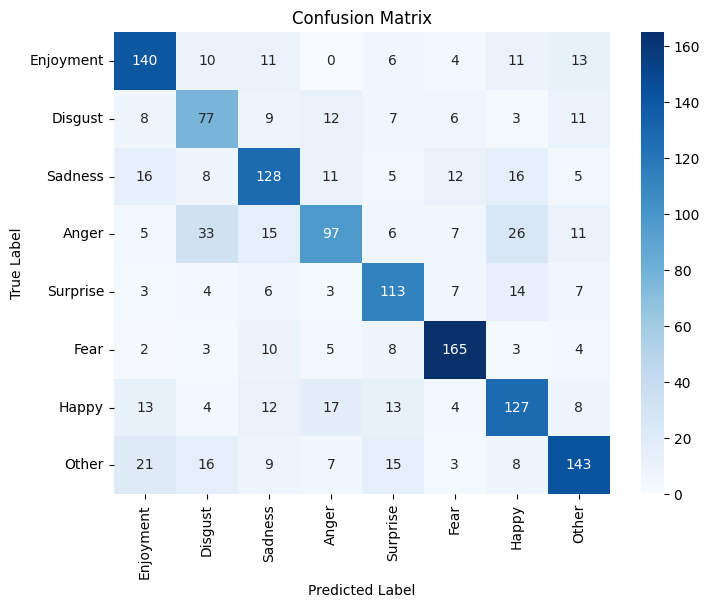

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

label_names = list(LABEL_MAP.keys())  # Lấy danh sách nhãn từ LABEL_MAP
plot_confusion_matrix(real_values, predicts, label_names)


In [21]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].Sentence)
    print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})')

--------------------------------------------------
lại 80 củ
Predicted: (Other) --vs-- Real label: (Anger)
--------------------------------------------------
buồn cho số_phận
Predicted: (Sadness) --vs-- Real label: (Anger)
--------------------------------------------------
cô ngu như lợn
Predicted: (Other) --vs-- Real label: (Enjoyment)
--------------------------------------------------
ok giá 59 k
Predicted: (Fear) --vs-- Real label: (Sadness)
--------------------------------------------------
ủa 20 triệu thì có tài với ai cái đó chỉ là đủ nuôi mồm nuôi_thân thôi chứ có chăm_lo cho bố_mẹ giành dụm cho gia_đình được đồng nào không 20 triệu ở thành_phố thì cuối tháng còn cái nịt mà kêu
Predicted: (Enjoyment) --vs-- Real label: (Disgust)
--------------------------------------------------
bán thì bán đi còn bảo bố mày bất_hạnh đéo thèm mua nữa
Predicted: (Surprise) --vs-- Real label: (Other)
--------------------------------------------------
không tiền cạp đất mà ăn à
Predicted: (Disgust)

In [22]:
def infer(text, tokenizer, max_len=256):
    print(f'Text: {text}')
    
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Sentiment: {class_names[y_pred]}')

In [23]:
infer('tôi phải thừa_nhận tôi cảm_thấy khá choáng_ngợp', tokenizer)

Text: tôi phải thừa_nhận tôi cảm_thấy khá choáng_ngợp
Sentiment: Surprise


In [24]:
# Tái tạo mô hình
model = SentimentClassifier(n_classes=8)
model.to(device)
model.load_state_dict(torch.load(f'/kaggle/working/phobert_fold1.pth'))
# Bọc mô hình bằng DataParallel nếu có nhiều hơn 1 GPU
if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)  # Sử dụng cả 2 GPU
model.eval()

DataParallel(
  (module): SentimentClassifier(
    (bert): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(64001, 768, padding_idx=1)
        (position_embeddings): Embedding(258, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_fe

In [25]:
# Định nghĩa hàm predict
def predict(text,model, tokenizer, max_len=256):
    print(f'Text: {text}')
    
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Sentiment: {class_names[y_pred]}')
# Ví dụ predict
text = "tôi rất vui hôm nay"
predict(text,model, tokenizer)

Text: tôi rất vui hôm nay
Sentiment: Happy


In [26]:
def evaluate_single_model(data_loader, model_path):
    model = SentimentClassifier(n_classes=8)
    state_dict = torch.load(model_path)
    if any(k.startswith('module.') for k in state_dict.keys()):
        state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)
    model.to(device)
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model.eval()

    predicts = []
    real_values = []
    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, pred = torch.max(outputs, dim=1)
            predicts.extend(pred.cpu())
            real_values.extend(targets.cpu())
    
    predicts = torch.stack(predicts)
    real_values = torch.stack(real_values)
    class_names = list(LABEL_MAP.keys())
    report = classification_report(real_values, predicts, target_names=class_names, output_dict=True)
    # return report
    return {'report': report, 'predicts': predicts, 'real_values': real_values}

# Đánh giá từng mô hình trên tập test
test_dataset = SentimentDataset(test_df, tokenizer, max_len=256)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
results = {}
for fold in range(8):
    model_path = f'/kaggle/working/phobert_fold{fold+1}.pth'
    result = evaluate_single_model(test_loader, model_path)
    accuracy = result['report']['accuracy']  # Accuracy tổng quát trên tập test
    print(f"Fold {fold+1} - Accuracy: {accuracy:.4f}")
    # print(report)
    results[fold+1] = result

# Chọn mô hình tốt nhất
best_fold = max(results, key=lambda k: results[k]['report']['accuracy'])
print(f"Best model: Fold {best_fold+1} with Accuracy: {results[best_fold]['report']['accuracy']:.4f}")
print("Full classification report for best model:")
print(classification_report(
    results[best_fold]['real_values'],  # Nhãn thực tế từ mô hình tốt nhất
    results[best_fold]['predicts'],     # Nhãn dự đoán từ mô hình tốt nhất
    target_names=class_names
))

Fold 1 - Accuracy: 0.6388
Fold 2 - Accuracy: 0.6434
Best model: Fold 3 with Accuracy: 0.6434
Full classification report for best model:
              precision    recall  f1-score   support

   Enjoyment       0.66      0.74      0.70       195
     Disgust       0.50      0.60      0.55       133
     Sadness       0.62      0.59      0.61       201
       Anger       0.58      0.42      0.49       200
    Surprise       0.67      0.68      0.68       157
        Fear       0.78      0.82      0.80       200
       Happy       0.55      0.71      0.62       198
       Other       0.77      0.59      0.67       222

    accuracy                           0.64      1506
   macro avg       0.64      0.64      0.64      1506
weighted avg       0.65      0.64      0.64      1506

